<a href="https://colab.research.google.com/github/JingQian87/AppliedDL/blob/master/A2_Part2_jq2282.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Collect a dataset of at least three landmarks.
In the dataset, I collect four landmarks, named as: Hamilton,  LeMarteleur,  Lion and  Uris (the sculpture in front of Uris Hall).

For each landmark, I made short videos from different angles and orientations.
Using ffmpeg, I extracted from the videos 100 images in train, 50 in validation and 25 in test for each landmark.

# 2. Write a model to classify your dataset using transfer learning. Run an experiment and report your results. 

In [0]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
import zipfile

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Step1. Load and explore data


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
local_zip = '/content/CUlandmarks.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
!ls '/tmp/'
!ls '/tmp/CUlandmarks/train/'

CUlandmarks  drivefs_ipc.0  drivefs_ipc.0_shell
Hamilton  LeMarteleur  Lion  Uris


In [6]:
base_dir = '/tmp/CUlandmarks'
import os
try:
  os.remove(os.path.join(base_dir,'.DS_Store'))
except OSError:
  pass
train_dir = os.path.join(base_dir,'train')
try:
  os.remove(os.path.join(train_dir,'.DS_Store'))
except OSError:
  pass
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir,'test')
try:
  os.remove(os.path.join(validation_dir,'.DS_Store'))
except OSError:
  pass
try:
  os.remove(os.path.join(test_dir,'.DS_Store'))
except OSError:
  pass

total_train = 0
for i in os.listdir(train_dir):
  try:
    os.remove(os.path.join(os.path.join(train_dir, i),'.DS_Store'))
  except OSError:
    pass
  tmp = len(os.listdir(os.path.join(train_dir, i)))
  print('Training ', i, ' images:', tmp)
  total_train += tmp
 
total_val = 0
for i in os.listdir(validation_dir):
  try:
    os.remove(os.path.join(os.path.join(validation_dir, i),'.DS_Store'))
  except OSError:
    pass
  tmp = len(os.listdir(os.path.join(validation_dir, i)))
  print('Validation ', i, ' images:', tmp)
  total_val += tmp
 
total_test = 0
for i in os.listdir(test_dir):
  try:
    os.remove(os.path.join(os.path.join(test_dir, i),'.DS_Store'))
  except OSError:
    pass
  tmp = len(os.listdir(os.path.join(test_dir, i)))
  print('Test ', i, ' images:', tmp)
  total_test += tmp
  
print("--")

print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total testing images:", total_test)

Training  Uris  images: 100
Training  Lion  images: 100
Training  LeMarteleur  images: 100
Training  Hamilton  images: 100
Validation  Uris  images: 50
Validation  Lion  images: 50
Validation  LeMarteleur  images: 50
Validation  Hamilton  images: 50
Test  Uris  images: 25
Test  Lion  images: 25
Test  LeMarteleur  images: 25
Test  Hamilton  images: 25
--
Total training images: 400
Total validation images: 200
Total testing images: 100


### Step2. Use VGG model

In [0]:
conv_base = VGG16(weights='imagenet',include_top=False, input_shape=(150, 150, 3))
#conv_base.summary()

TARGET_SHAPE = 150
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))#from block5 of VGG16
    labels = np.zeros(shape=(sample_count, 4))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base.predict(inputs_batch)
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 400)
validation_features, validation_labels = extract_features(validation_dir, 200)

Instructions for updating:
Colocations handled automatically by placer.
Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


In [0]:
FLATTENED_SHAPE = 4 * 4 * 512

train_features = np.reshape(train_features, (total_train, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (total_val, FLATTENED_SHAPE))
EPOCHS = 50
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 400 samples, validate on 200 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
400/400 [==============================] - 0s 1ms/sample - loss: 0.8209 - acc: 0.7750 - val_loss: 0.0359 - val_acc: 1.0000
Epoch 2/50
400/400 [==============================] - 0s 299us/sample - loss: 0.0207 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 3/50
400/400 [==============================] - 0s 298us/sample - loss: 0.0090 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 4/50
400/400 [==============================] - 0s 332us/sample - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 5/50
400/400 [==============================] - 0s 299us/sample - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 6/50
400/400 [==============================] - 0s 290us/sample - loss: 8.1493e-04 - acc: 1.0000 - val_loss

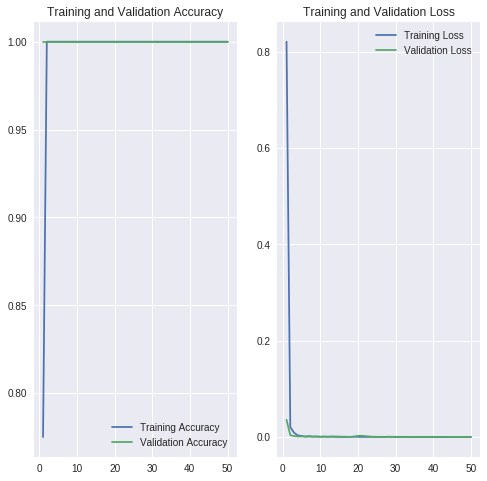

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## <font color='blue'>Report of Part 2.2<font>

In this problem, I used VGG16 as convolutionary base followed with dense classification layer for the model to classify the dataset.
I used approach one in the example script without fine tuning.

From the plot of accuracy and loss of training and validation dataset above, we could see that both dataset get 100% accuracy in the second epoch.

There may be several reasons for such result: <br>
* VGG16 have trained on very large dataset with many parameters, which caused overfitting in my small dataset. <br>
* Although I took images from different angles and orientations, the images in one class are not diverse enough. <br>
* Among these sculptures, one is a geometry, one is a lion and the other two are human statues. The sculptures between different classes are quite diverse, which may lead to high accuracy of classification.

# 3. Explore the available pretrained models
How small of a model (in terms of the number of parameters) can you write to classify these images reasonably well? Explore the available pretrained models, and see if any are suitable. Run an experiment and report your results.

#### 3.1. ResNet50 model

In [6]:
from keras.applications.resnet50 import ResNet50
conv_base2 = ResNet50(weights='imagenet',include_top=False, input_shape=(150, 150, 3))
TARGET_SHAPE = 150
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 5,5,2048))#from ResNet
    labels = np.zeros(shape=(sample_count, 4))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base2.predict(inputs_batch)
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 400)
validation_features, validation_labels = extract_features(validation_dir, 200)


FLATTENED_SHAPE = 5*5*2048

train_features = np.reshape(train_features, (total_train, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (total_val, FLATTENED_SHAPE))
EPOCHS = 50
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 400 samples, validate on 200 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
400/400 [==============================] - 1s 3ms/sample - loss: 4.3408 - acc: 0.2450 - val_loss: 1.4336 - val_acc: 0.3100
Epoch 2/50
400/400 [==============================] - 0s 1ms/sample - loss: 1.5462 - acc: 0.3650 - val_loss: 1.2104 - val_acc: 0.5300
Epoch 3/50
400/400 [==============================] - 0s 1ms/sample - loss: 1.2030 - acc: 0.4475 - val_loss: 1.0934 - val_acc: 0.6800
Epoch 4/50
400/400 [==============================] - 0s 1ms/sample - loss: 1.1391 - acc: 0.4850 - val_loss: 1.0140 - val_acc: 0.8100
Epoch 5/50
400/400 [==============================] - 0s 1ms/sample - loss: 1.0852 - acc: 0.5275 - val_loss: 0.9867 - val_acc: 0.8400
Epoch 6/50
400/400 [===================

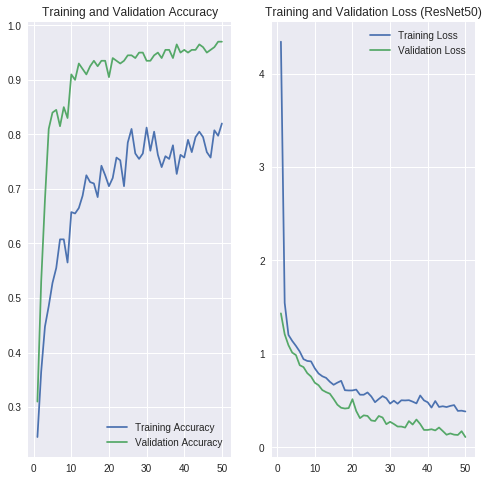

In [7]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (ResNet50)')
plt.show()

#### 3.1. InceptionV3 model

In [9]:
from keras.applications.inception_v3 import InceptionV3
conv_base3 = InceptionV3(weights='imagenet',include_top=False, input_shape=(150, 150, 3))
#conv_base3.summary()
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 2048))#from block5 of VGG16
    labels = np.zeros(shape=(sample_count, 4))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base3.predict(inputs_batch)
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 400)
validation_features, validation_labels = extract_features(validation_dir, 200)

FLATTENED_SHAPE = 3 * 3 * 2048

train_features = np.reshape(train_features, (total_train, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (total_val, FLATTENED_SHAPE))
EPOCHS = 50
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history3 = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))

Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Train on 400 samples, validate on 200 samples
Epoch 1/50
400/400 [==============================] - 2s 4ms/sample - loss: 2.6683 - acc: 0.7325 - val_loss: 0.5427 - val_acc: 0.9400
Epoch 2/50
400/400 [==============================] - 0s 479us/sample - loss: 1.0039 - acc: 0.9225 - val_loss: 0.1789 - val_acc: 0.9750
Epoch 3/50
400/400 [==============================] - 0s 494us/sample - loss: 0.5533 - acc: 0.9625 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 4/50
400/400 [==============================] - 0s 490us/sample - loss: 0.1927 - acc: 0.9800 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 5/50
400/400 [==============================] - 0s 483us/sample - loss: 0.1157 - acc: 0.9925 - val_loss: 0.1508 - val_acc: 0.9900
Epoch 6/50
400/400 [==============================] - 0s 504us/sample - loss: 0.2949 - acc: 0.9750 - val_loss: 0.0223 - val_acc: 0.9950
Epoch 7/50
400/400 [==============================] - 

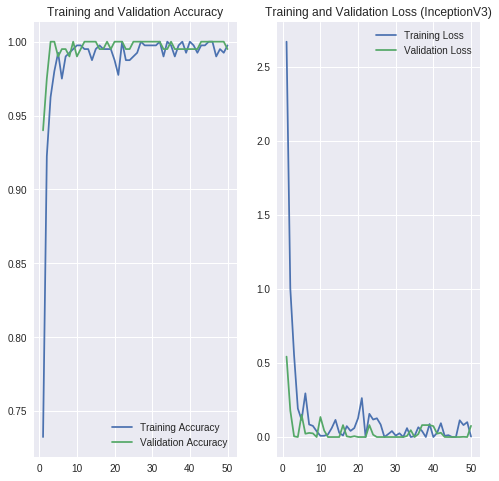

In [10]:
acc = history3.history['acc']
val_acc = history3.history['val_acc']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (InceptionV3)')
plt.show()

#### 3.2. MobileNetV2 model

In [7]:
from keras.applications.mobilenet_v2 import MobileNetV2
conv_base4 = MobileNetV2(weights='imagenet',include_top=False, input_shape=(128,128, 3))
conv_base4.summary()

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


9412608/9406464 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
______________________________________________

In [8]:
datagen = ImageDataGenerator(rescale=1./255)

TARGET_SHAPE = 128
BATCH_SIZE = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 1280))#from ResNet
    labels = np.zeros(shape=(sample_count, 4))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base4.predict(inputs_batch)
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 400)
validation_features, validation_labels = extract_features(validation_dir, 200)


FLATTENED_SHAPE = 4 * 4 * 1280

train_features = np.reshape(train_features, (total_train, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (total_val, FLATTENED_SHAPE))
EPOCHS = 50
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history4 = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))

Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 400 samples, validate on 200 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
400/400 [==============================] - 1s 3ms/sample - loss: 3.3953 - acc: 0.7175 - val_loss: 0.1843 - val_acc: 0.9800
Epoch 2/50
400/400 [==============================] - 0s 520us/sample - loss: 0.0566 - acc: 0.9900 - val_loss: 0.4585 - val_acc: 0.9550
Epoch 3/50
400/400 [==============================] - 0s 515us/sample - loss: 0.3470 - acc: 0.9675 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4/50
400/400 [==============================] - 0s 533us/sample - loss: 6.4244e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 5/50
400/400 [==============================] - 0s 514us/sample - loss: 0.0658 - acc: 0.9900 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 6/50
400/

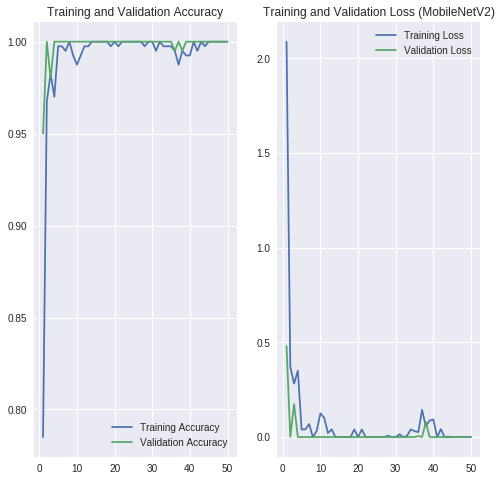

In [16]:
acc = history4.history['acc']
val_acc = history4.history['val_acc']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (MobileNetV2)')
plt.show()

In [9]:
test_features, test_labels = extract_features(test_dir, 100)
test_features = np.reshape(test_features, (total_test, FLATTENED_SHAPE))

model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

Found 100 images belonging to 4 classes.
100/100 [==============================] - 0s 220us/sample - loss: 1.1921e-07 - acc: 1.0000


[1.1920930376163597e-07, 1.0]

## <font color='blue'> Report of Part 2.3. <font>
In this problem, I explored three different models, ResNet50, InceptionV3 and  MobileNetV2. 
  So in total, I used four models for the same dataset.
  
From the document, we know:
* VGG16 has 138357544 parameters and depth = 23. 
* ResNet50 and InceptionV3 both have one magnitude smaller number of parameters, which are 25636712 and 23851784 respectively. 
InceptionV3 has depth=159.
* MobileNetV2 has the fewest parameters among the pretrained models listed, which is 3538984.
MobileNetV2 has depth 88.
  
In this script, I set the same parameters for the four models, except for one parameter, the TARGET_SHAPE of MobileNetV2 is set to 128 due to its fixed options of input shape while others is 150.
  
From the accuracy plot of training and validation datasets from four models, one could have following observations:
* VGG16 reaches 100% accuracy earliest for both training and validation, which may due to its large parameters.
* ResNet50 has the lowest accuracy for both training and validation. Moreover, ResNet50 has higher validation accuracy than training.
* InceptionV3 and MobileNetV2 have similar performance: they reach 100% accuracy for training and validation datasets after about 10 epoches, which is slower than VGG16. Also, the accuracy plots are zigzag while the plots of VGG16 is very smooth.
  
Since MobileNetV2, which has the smallest number of parameters, has good performance on the validation dataset, I choose the MobileNetV2-based model to do classification.
 In the code block above, I evaluate this model on the test dataset, which has 100 images over 4 classes (25 images per one) and reached 100% accuracy.